# PRUEBAS DE CÓDIGO

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
import cv2
from scipy import fftpack as fft

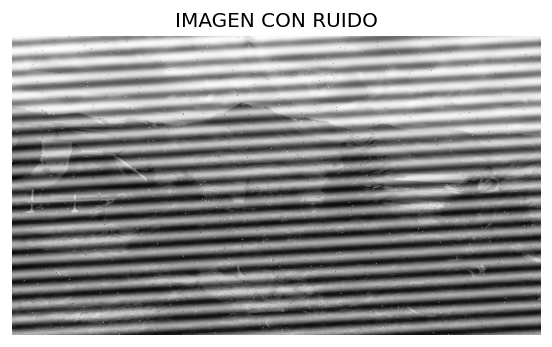

In [2]:
im_ori = cv2.imread(".images/o_ruido.jpg")
frame_ruido = cv2.cvtColor(im_ori, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.set_title('IMAGEN CON RUIDO')
ax.imshow(frame_ruido,cmap=plt.cm.Greys_r)
ax.axis('off');

* Tipos de Ruido:
        - Impulsivo(Sal y pimienta)
        - Periódico

Eliminamos el ruido impulsivo(sal y pimienta)

In [3]:
frame_limpio = cv2.medianBlur(frame_ruido, 5)

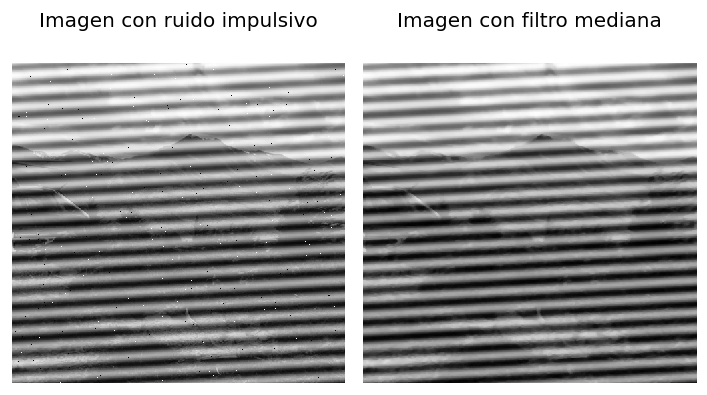

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True, sharex=True, sharey=True)
ax[0].matshow(frame_ruido[:, 100:600], cmap=plt.cm.Greys_r)     
ax[0].set_title('Imagen con ruido impulsivo')
ax[0].axis('off')
ax[1].matshow(frame_limpio[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].set_title('Imagen con filtro mediana')
ax[1].axis('off');

Eliminamos el ruido periódico utilizando una máscara en frecuencia

In [ ]:
def create_mask(dims, frequency, size=3):
    freq_int = int(frequency*dims[0])
    mask = np.ones(shape=(dims[0], dims[1]))
    mask[dims[0]//2-size-freq_int:dims[0]//2+size-freq_int, 
         dims[1]//2-size:dims[1]//2+size] = 0 
    mask[dims[0]//2-size+freq_int:dims[0]//2+size+freq_int, 
          dims[1]//2-size:dims[1]//2+size] = 0
    return mask


freq_x = fft.fftshift(fft.fftfreq(n=frame_limpio.shape[1]))
freq_y = fft.fftshift(fft.fftfreq(n=frame_limpio.shape[0]))

S_img = fft.fftshift(fft.fft2(frame_limpio))
espectro_filtrado = S_img*create_mask(S_img.shape, 0.04)   
# Reconstrucción
img_reconstructed = np.real(fft.ifft2(fft.ifftshift(espectro_filtrado)))

fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
#ax[0].matshow(frame_limpio, cmap=plt.cm.Greys_r) 
#ax[0].axis('off');
ax[0].imshow(np.log(1+np.abs(espectro_filtrado))[200:-200, 350:-350], cmap=plt.cm.Spectral_r)
ax[0].set_title("Espectro en frecuencias")
ax[0].axis('off');
ax[1].matshow(img_reconstructed, cmap=plt.cm.Greys_r)
ax[1].set_title("Imagen filtrada")
ax[1].axis('off');

In [ ]:
frame = img_reconstructed

----

### Transformación

In [ ]:
frame_size = frame.shape
dct_matrix = np.zeros(shape=frame_size)

DCT2 = lambda g, norm='ortho': fft.dct(fft.dct(g, axis=0, norm=norm), axis=1, norm=norm)
# Se recorre el frame en bloques de 8x8
for i in range(0, frame_size[0], 8):
    for j in range(0, frame_size[1], 8):
        dct_matrix[i:(i+8),j:(j+8)] = DCT2(frame[i:(i+8),j:(j+8)])

In [ ]:
#print("dct_matrix: %s" %(dct_matrix))
#print("Tamaño dct_matrix: %s" %(repr(dct_matrix.shape)))
#print("Tipo dct_mattrix  : %s" %(dct_matrix.dtype))

In [ ]:
frame_transformado = dct_matrix
#print(frame_transformado)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8, 3), tight_layout=True)
ax[0].imshow(frame,  cmap=plt.cm.Greys_r)
ax[0].set_title('Frame original')
ax[0].axis('off');

ax[1].imshow(frame_transformado, cmap=plt.cm.Greys_r)
ax[1].set_title('Frame Transformado')
ax[1].axis('off');

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(np.uint8(frame_transformado), cmap=plt.cm.Greys_r)
ax.set_title('Frame Transformado int')
ax.axis('off');

----

### Cuantización 

In [ ]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

In [ ]:
frame_size = frame_transformado.shape
im_dct = np.zeros(shape=frame_size)
# nnz = np.zeros(dct_matrix.shape) #
#porcentaje de cuantizacion?
IDCT2 = lambda G, norm='ortho': fft.idct( fft.idct(G, axis=0, norm=norm), axis=1, norm=norm)
porcentaje = 50
if (porcentaje < 50):
    S = 5000/porcentaje
else:
    S = 200 - 2*porcentaje

Q_dyn = np.floor((S*Q + 50) / 100);
Q_dyn[Q_dyn == 0] = 1 
for i in range(0, frame_size[0], 8):
    for j in range(0, frame_size[1], 8):
        quant = np.round(dct_matrix[i:(i+8),j:(j+8)]/Q_dyn)
        im_dct[i:(i+8),j:(j+8)] = IDCT2(quant)
            

#frame = np.uint8(im_dct)

In [ ]:
#print("im_dct: %s" %(im_dct))
#print("Tamaño im_dct: %s" %(repr(im_dct.shape)))
#print("Tipo im_dct  : %s" %(im_dct.dtype))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8, 3), tight_layout=True)
ax[0].imshow(frame,  cmap=plt.cm.Greys_r)
ax[0].set_title('Frame original')
ax[0].axis('off');

ax[1].imshow(np.uint8(im_dct), cmap=plt.cm.Greys_r)
ax[1].set_title('Frame Cuantizado')
ax[1].axis('off');

In [ ]:
np.uint8(im_dct)

In [ ]:
vector = np.uint8(im_dct).reshape(1,407040)
#len(np.uint8(im_dct))

In [ ]:
vector = vector[0]

In [ ]:
from collections import Counter
Counter(vector).most_common()

In [ ]:
# Implemetación adaptada de https://rosettacode.org/wiki/Huffman_coding#Python
import heapq
# Construir dendograma con las probabilidades ordenadas
dendograma = [[frequencia/len(vector), [simbolo, ""]] for simbolo, frequencia in Counter(vector).items()]
heapq.heapify(dendograma)
# Crear el código
while len(dendograma) > 1:
    lo = heapq.heappop(dendograma)
    hi = heapq.heappop(dendograma)
    for codigo in lo[1:]:
        codigo[1] = '0' + codigo[1]
    for codigo in hi[1:]:
        codigo[1] = '1' + codigo[1]
    heapq.heappush(dendograma, [lo[0] + hi[0]] + lo[1:] + hi[1:])
# Convertir código a diccionario
dendograma = sorted(heapq.heappop(dendograma)[1:])
dendograma = {simbolo : codigo for simbolo, codigo in dendograma} 
display(dendograma)